# **LABORATORIO 04**
Aplicar un Red Neuronal Recurrente, para lograr predecir la calidad del agua, a lo largo de todo el año 2024 y 2025, para lo cual debe investigar:
 1. Cuales son los indicadores que se deben considerar para establecer el valor del indice de calidad de agua, considerando los valores que se establecen como limites, generar un dataset sintetico para encarar este problema.
 2. Usted debe decidir que modelo de rnn es el mas preciso y justificar detalladamente el por que de su eleccion.

No se olvide considerar un conjunto de datos suficiente, que represente varios años, varias temporadas y otros aspectos que usted considere necesario.


# **Elaboración del dataset**

Nos basamos en los documentos, analizando las tablas extrajimos los parametros a tomar en cuenta y sus respectivos limites.

En base a esos datos generamos datos aleatorios que se mueven entre los limites indicados. Esto para X.

En el caso de Y corresponde a un valor entre 0 y 1 (menor a mayor calidad del agua) que se obtiene con una ponderacion de los atributos de X, donde se penaliza si el atributo pasa el limite.

In [2]:
import numpy as np

# Definir límites para cada característica
limits = {
    'Cianuro_libre': 0.2,
    'Cromo_+6': 0.1,
    'DBO5': 80,
    'DQO': 250,
    'Hierro': 1,
    'pH_min': 6.0,
    'pH_max': 9.0,
    'Sólidos_Suspendidos_Totales': 60,
    'Sulfuros': 2,
    'Fenoles': 1,
    'Coliformes_Termotolerantes': 1000
}

# Número de muestras y días
num_samples = 100
num_days = 10000
num_future_days = 365

# Inicializar X
X = np.zeros((num_samples, num_days, len(limits)))

# Crear datos aleatorios para X dentro de los límites
for i, (key, limit) in enumerate(limits.items()):
    if key in ['pH_min', 'pH_max']:
        X[..., i] = np.random.uniform(low=limit - 1.0, high=limit + 1.0, size=(num_samples, num_days))
    else:
        X[..., i] = np.random.uniform(low=0, high=limit * 2, size=(num_samples, num_days))

# Crear Y basado en X, en este caso asumimos una función simple para ilustrar
def calculate_quality(x):
    # Simple heurística para generar la calidad del agua basada en los límites
    quality = 1.0
    # Change x.shape[1] to x.shape[0] because x is a 1D array
    for i in range(x.shape[0]):  # para cada día
        if (x[i] > np.array(list(limits.values()))[i]).any():  # si alguna característica supera el límite
            quality -= 0.1  # penalizar calidad
    return np.clip(quality, 0, 1)  # asegurar que esté entre 0 y 1

# Inicializar Y
Y = np.zeros((num_samples, num_future_days))

# Calcular calidad para cada muestra
for i in range(num_samples):
    # Usar la calidad de los días históricos para predecir los días futuros
    Y[i] = calculate_quality(X[i, -1, :])  # Usar el último día de los datos históricos para calcular la calidad

# Dividir en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Se generaron 10000 datos para pruebas que corresponden a los 10000 dias anteriores a la temporada 2024-2025, y 365 dias para test que responden a la temporada 2024-2025 que se va a tratar de predecir

In [3]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(80, 10000, 11)
(80, 365)
(20, 10000, 11)
(20, 365)


In [4]:
print(Y_test[:5])

[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.5 0.5 0.5 ... 0.5 0.5 0.5]
 [0.4 0.4 0.4 ... 0.4 0.4 0.4]
 [0.6 0.6 0.6 ... 0.6 0.6 0.6]
 [0.7 0.7 0.7 ... 0.7 0.7 0.7]]


In [5]:
print(X_test[:5])

[[[2.58088290e-01 4.41755386e-02 9.75594367e+01 ... 3.91628657e+00
   2.75397232e-01 1.46602220e+02]
  [1.36259986e-01 1.24252347e-01 7.41593534e+01 ... 3.01896184e+00
   1.88303035e-01 1.89053824e+03]
  [3.76365788e-01 2.52881902e-02 1.18395518e+02 ... 5.73990859e-01
   1.30559568e+00 1.11987729e+03]
  ...
  [1.96260972e-01 6.32879528e-02 8.10382910e+01 ... 1.92601283e+00
   8.20117931e-01 1.67217212e+03]
  [2.92072555e-01 1.73124185e-01 1.36767004e+02 ... 4.70972345e-01
   5.15255742e-01 1.20712685e+03]
  [3.37247957e-01 8.63409752e-02 8.78382339e+01 ... 2.61824319e+00
   1.10069356e+00 1.34675406e+03]]

 [[1.95482490e-01 2.98400311e-02 1.01911317e+02 ... 3.31713732e+00
   1.14199459e+00 2.86421653e+02]
  [2.55332822e-01 1.53083255e-01 1.07054702e+02 ... 2.70973125e+00
   1.94150033e+00 1.45885154e+03]
  [1.96458368e-01 1.74149735e-01 9.86318661e+01 ... 1.42346019e+00
   1.77007789e+00 1.21275233e+02]
  ...
  [1.42375781e-01 1.97915570e-01 1.42707848e+02 ... 2.29261721e+00
   1.20414

# **Elección del modelo**

El modelo escogido es el LSTM, ya que suaviza el problema de un rnn normal, que es que no puede manterner las dependencias a largo plazo, debido a que los gradientes se hacen muy pequeños o muy grandes. El LSTM soluciona esto, ya que:
a) Usa dos conjuntos distintos de valores en las capas ocultas. (h y c).
b) Usa distintas puertas para controlar el flujo de información.

Se multiplica X por H, pero ahora tenemos distintas matrices de pesos para cada una de las puertas.
Tras calcular Wxi X + Whi h aplicamos la función de activación sigmoide para el flujo de las puertas f, i, o. F controla cuanta info pasa a long term,c, debe olvidarse. La puerta I controla cuanta info nueva entra a long term, c. Y O controla la info que pasa a short-term h.

In [6]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=5, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 because of bidirectional

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Crear el modelo
input_size = 11  # Número de características
hidden_size = 64  # Tamaño del estado oculto
output_size = 365  # Número de días futuros
model = LSTMModel(input_size, hidden_size, output_size)

# **Arquitectura del modelo**



1. **Capa LSTM**:
   - **Número de Características de Entrada (`input_size`)**: 11. Esto significa que cada entrada a la LSTM tiene 11 características.
   - **Número de Unidades Ocultas (`hidden_size`)**: 64. Cada celda LSTM tiene 64 unidades que representan el estado interno de la red.
   - **Número de Capas LSTM (`num_layers`)**: 5. El modelo utiliza 5 capas LSTM apiladas para capturar características complejas en la secuencia de datos.
   - **Bidireccionalidad**: El modelo es bidireccional, lo que significa que las secuencias se procesan en ambas direcciones (del pasado al futuro y del futuro al pasado). Esto duplica el tamaño del estado oculto en la salida de la LSTM.
   - **Dropout**: 0.3. Se aplica una tasa de dropout del 30% durante el entrenamiento para evitar el sobreajuste.

2. **Capa Fully Connected (fc)**:
   - **Número de Unidades de Entrada**: `hidden_size * 2` (128) debido a la bidireccionalidad de la LSTM.
   - **Número de Unidades de Salida (`output_size`)**: 365. Esta capa toma la salida de la LSTM y la convierte en una predicción para los 365 días futuros.


In [7]:
# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMModel(
  (lstm): LSTM(11, 64, num_layers=5, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=365, bias=True)
)

In [8]:
#importar el optimizer
import torch.optim as optim

In [9]:
# Función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configurar Early Stopping y Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Convertir datos a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# **Entrenamiento del modelo**



1. **Preparación de Datos**:
   - Se utiliza un `DataLoader` para manejar los datos de entrenamiento. Este `DataLoader` divide los datos en lotes (`batch_size = 16` en este caso) y los baraja (`shuffle=True`) para mejorar la generalización del modelo.

2. **Bucle de Entrenamiento**:
   - **Número de Épocas (`num_epochs`)**: 100. El modelo se entrena durante 100 iteraciones sobre todo el conjunto de datos.
   - **Iteración sobre Lotes**:
     - **Entrada y Salida del Lote**: Para cada lote en el `DataLoader`, se obtienen las características de entrada (`batch_X`) y las etiquetas (`batch_Y`).
     - **Transferencia al Dispositivo**: Los datos del lote se trasladan al dispositivo (GPU o CPU).
     - **Cálculo de Predicciones**: El modelo realiza predicciones para el lote de datos.
     - **Cálculo de Pérdida**: Se calcula la pérdida entre las predicciones y las etiquetas reales usando la función de pérdida (`criterion`).
     - **Actualización de Gradientes**: Se realiza el retropropagación de la pérdida para calcular los gradientes.
     - **Optimización**: Los parámetros del modelo se actualizan usando el optimizador (`optimizer`).
   
3. **Actualización del Scheduler**:
   - **Scheduler**: Se ajusta el learning rate usando un `ReduceLROnPlateau`, que reduce la tasa de aprendizaje si la pérdida no mejora durante un número de épocas (`patience`).

4. **Impresión de Resultados**:
   - Cada 10 épocas, se imprime la pérdida (`loss`) para monitorear el progreso del entrenamiento.


In [11]:
# Supongamos que tienes un DataLoader para el entrenamiento
from torch.utils.data import DataLoader, TensorDataset

# Crear el DataLoader con un tamaño de lote más pequeño
batch_size = 16  # Ajusta este valor según la memoria disponible
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Modificar el bucle de entrenamiento para usar DataLoader
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()

    # Actualizar el scheduler
    scheduler.step(loss.item())

    if (epoch + 1) % 10 == 0:  # Imprimir cada 10 épocas
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0299
Epoch [20/100], Loss: 0.0329
Epoch [30/100], Loss: 0.0301
Epoch [40/100], Loss: 0.0203
Epoch [50/100], Loss: 0.0381
Epoch [60/100], Loss: 0.0193
Epoch [70/100], Loss: 0.0363
Epoch [80/100], Loss: 0.0194
Epoch [90/100], Loss: 0.0260
Epoch [100/100], Loss: 0.0321


In [12]:
# Convertir datos de prueba a tensores
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, Y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0276


In [13]:
print(Y_test.shape)

(20, 365)


In [14]:
# Supongamos que ya has definido estas variables en tu código
n_steps = 365  # El número de pasos en el pasado que se usa para las predicciones
n_predictions = 365  # El número de pasos futuros que estamos prediciendo

# **Predicción de la calidad del agua para 2024-2025**

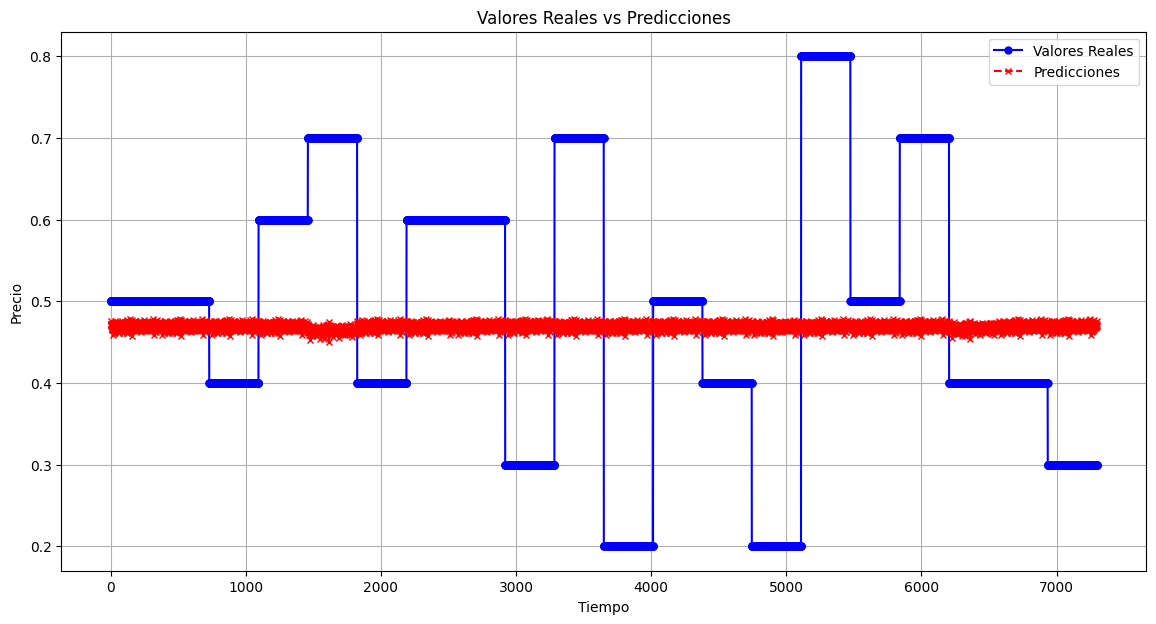

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_actuals(y_true, y_pred, n_steps, n_predictions):
    """
    Función para graficar las predicciones y los valores reales.
    :param y_true: Valores reales (array de numpy).
    :param y_pred: Predicciones del modelo (array de numpy).
    :param n_steps: Número de pasos pasados.
    :param n_predictions: Número de pasos futuros predichos.
    """
    # Plotear los valores reales y las predicciones
    plt.figure(figsize=(14, 7))

    # Graficar los valores reales
    plt.plot(y_true, label='Valores Reales', color='blue', linestyle='-', marker='o', markersize=5)

    # Graficar las predicciones
    plt.plot(y_pred, label='Predicciones', color='red', linestyle='--', marker='x', markersize=5)

    # Configurar etiquetas y leyenda
    plt.xlabel('Tiempo')
    plt.ylabel('Precio')
    plt.title('Valores Reales vs Predicciones')
    plt.legend()
    plt.grid(True)
    plt.show()

# Convertir datos de prueba a numpy arrays si aún no lo has hecho
Y_test_np = Y_test_tensor.cpu().numpy().flatten()
predictions_np = predictions.cpu().numpy().flatten()

# Graficar
plot_predictions_vs_actuals(Y_test_np, predictions_np, n_steps, n_predictions)


In [16]:
# Imprimir los primeros cinco valores reales y las primeras cinco predicciones
print("Primeros cinco valores reales:")
print(Y_test_np[:5])

print("Primeros cinco valores predichos:")
print(predictions_np[:5])

Primeros cinco valores reales:
[0.5 0.5 0.5 0.5 0.5]
Primeros cinco valores predichos:
[0.47149223 0.47267675 0.47601396 0.47200352 0.46969354]


In [18]:
import numpy as np

# Configura la semilla para que los resultados sean reproducibles
np.random.seed(42)

# Número de muestras aleatorias que deseas imprimir
num_samples = 10

# Seleccionar índices aleatorios
indices = np.random.choice(len(Y_test_np), num_samples, replace=False)

# Imprimir los valores seleccionados
print("Tomamos al azar cinco valores reales:")
print(Y_test_np[indices])

print("Sus predicciones correspondientes cinco valores predichos:")
print(predictions_np[indices])

Tomamos al azar cinco valores reales:
[0.4 0.2 0.4 0.2 0.7 0.4 0.2 0.5 0.4 0.6]
Sus predicciones correspondientes cinco valores predichos:
[0.47218502 0.47094756 0.46526387 0.4678756  0.46351904 0.46158615
 0.47313905 0.4631998  0.46509022 0.47011146]


In [19]:
import numpy as np

# Convertir datos de prueba a numpy arrays si aún no lo has hecho
Y_test_np = Y_test_tensor.cpu().numpy().flatten()
predictions_np = predictions.cpu().numpy().flatten()

# Calcular el Error Absoluto Medio (MAE)
mae = np.mean(np.abs(Y_test_np - predictions_np))

# Calcular el rango de los valores reales
range_y = np.max(Y_test_np) - np.min(Y_test_np)

# Calcular el porcentaje de precisión
percentage_precision = 100 - (mae / range_y * 100)

print(f'MAE: {mae:.4f}')
print(f'Rango de valores reales: {range_y:.4f}')
print(f'Porcentaje de Precisión: {percentage_precision:.2f}%')


MAE: 0.1382
Rango de valores reales: 0.6000
Porcentaje de Precisión: 76.96%


# **Conclusiones**

- A pesar de tener una pérdida muy baja en el entrenamiento, el modelo tiene problemas para predecir conforme avanza el tiempo.

- La presición de 76 % es un poco engañosa, puesto que como los resultados de la predicción son parecidos entre todos, los de los datos reales varian mucho, eso no se capta en la predicción